In [1]:
import tinycudann as tcnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


from PIL import Image
import numpy as np

import time
import einops

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def make_grid(shape, flatten=True, center=False):
    """
    Make grid coordinates in the range [-1, 1].
    If center is True, the coordinates are at grid centers.
    Else, the coordinates reach the [-1, 1] boundary.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if center:
            c = 1 / n
            seq = -1 + c + 2 * c * torch.arange(n).float()
        else:
            c = 1 / (n - 1)
            seq = -1 + 2 * c * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs, indexing="ij"), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret

# Load image

In [3]:
image_path = "./data/kodim/kodim23.png"
img = Image.open(image_path)
sidelength = 512
image_transform = transforms.Compose(
    [
        transforms.CenterCrop(min(img.size)),
        transforms.Resize((sidelength, sidelength)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ]
)
img = image_transform(img)  # c x h x w
gt = einops.rearrange(img, "c h w -> (h w) c")
gt_img = einops.rearrange(img, "c h w -> h w c").cpu().detach().numpy() * 0.5 + 0.5

n_input_dims = 2
n_output_dims = 3

In [4]:
def img_fft(img):
    # img: np.array, shape (sidelength, sidelength)
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(img))) + 1e-10)

def rgb2gray(rgb):
    # rgb: np.array, shape (sidelength, sidelength, 3) value range [0, 1]
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

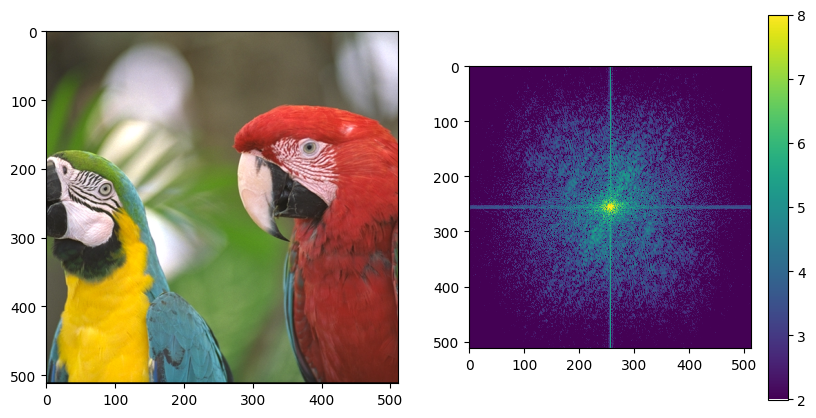

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gt_img)
plt.colorbar(
    plt.imshow(img_fft(rgb2gray(gt_img)), vmin=2, vmax=8, interpolation="none"),
    ax=axes[1],
)
plt.show()

# Test tinycudann installation

In [ ]:
random_seed = 42

decoder_hidden_dims = 32
decoder_output_dims = 4
grid_config = {
    "otype": "HashGrid",
    "n_levels": 10,
    "n_features_per_level": 2,
    "log2_hashmap_size": 12,
    "base_resolution": 4,
    "per_level_scale": 1.5,
}
grid = tcnn.Encoding(n_input_dims, grid_config, seed=random_seed)
decoder = tcnn.Network(
    grid.n_output_dims,
    decoder_output_dims,
    {
        "otype": "FullyFusedMLP",
        "activation": "ReLU",
        "output_activation": "None",
        "n_neurons": decoder_hidden_dims,
        "n_hidden_layers": 1,
    },
    seed=random_seed,
)

# number of trainable parameters in the grid in MB
# print(f"Grid size: {sum(p.numel() for p in grid.parameters() if p.requires_grad)}")
print(
    f"Grid size: {sum(p.numel() for p in grid.parameters() if p.requires_grad) * 4 / 1024 / 1024:.2f} MB"
)
print(
    f"Decoder size: {sum(p.numel() for p in decoder.parameters() if p.requires_grad) * 4 / 1024 / 1024:.2f} MB"
)

x = torch.rand(10, n_input_dims)
y = grid(x)
z = decoder(y)
print(f"Input shape: {x.shape}")
print(f"Grid output shape: {y.shape}")
print(f"Decoder output shape: {z.shape}")

Grid size: 0.12 MB
Decoder size: 0.01 MB
Input shape: torch.Size([10, 2])
Grid output shape: torch.Size([10, 20])
Decoder output shape: torch.Size([10, 4])


/fs/nexus-scratch/hfengac/anaconda3/envs/sasnet/lib/python3.9/site-packages/tinycudann/modules.py:182: UserWarning: input must be a CUDA tensor, but isn't. This indicates suboptimal performance.
  warnings.warn("input must be a CUDA tensor, but isn't. This indicates suboptimal performance.")


# SIREN and SASNet

In [ ]:
from typing import List


class MLP(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_features: List[int],
        out_features: int,
        hidden_layers=1,
        act_func=torch.relu,
        output_act_func=torch.sigmoid,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_layers = hidden_layers
        self.hidden_features = hidden_features

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features, hidden_features[0]))
        if hidden_layers > 1:
            for i in range(1, hidden_layers):
                self.layers.append(
                    nn.Linear(hidden_features[i - 1], hidden_features[i])
                )
        self.final_layer = nn.Linear(hidden_features[-1], out_features)

        self.act_func = act_func
        self.output_act_func = output_act_func

    def forward(self, x):
        for _, layer in enumerate(self.layers):
            x = self.act_func(layer(x))

        return self.output_act_func(self.final_layer(x))


class SineLayer(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        is_first: bool = False,
        omega_0: int = 30,
        period: float = 0,
        init_mode: str = "sampling",
        act_func=torch.sin,
        seed=42,
        **kwargs,
    ):
        """
        in_features: int, number of input features
        out_features: int, number of output features
        bias: bool, whether to include bias in the layer
        is_first: bool, whether this is the first layer in the network
        omega_0: int, magic number from SIREN paper
        period: float, period of the input signal. Only used if init_mode is not "none" and is_first is True
        init_mode: str, initialization mode. Options are "sampling", "uniform", "none"
        act_func: torch function, activation function, e.g., torch.sin, F.relu

        other kwargs are passed:
            bandlimit: int, bandlimit of the input signal. Only used if init_mode is not "none" and is_first is True
            low_range: int, upper bound of the low frequency neurons. Only used if init_mode is not "none" and is_first is True
            perc_low_freqs: float, percentage of low frequency neurons. Only used if init_mode is not "none" and is_first is True
            num_high_freq_bands: int, number of high frequency bands. Only used if init_mode is not "none" and is_first is True
            num_hidden_groups: int, number of hidden neuron groups. Only used if is_first is False
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.omega_0 = omega_0
        self.is_first = is_first
        self.act_func = act_func
        self.period = period
        self.init_mode = init_mode
        self.bias = bias
        self.seed = seed

        # The starting position of each neuron group in this layer
        #   for layers without neuron groups, it is [0]
        #   for the first layer, it is [0, n_low_freqs, *n_high_freqs_lists]
        self.group_offsets = [0]
        self.neuron_groups = nn.ModuleList()

        if self.is_first and self.init_mode != "none":
            self.__bandlimit = kwargs.get("bandlimit", omega_0)
            self.__low_range = kwargs.get("low_range", 15)
            self.__perc_low_freqs = kwargs.get("perc_low_freqs", 0.7)

            print(
                f"{self.__bandlimit = }, {self.__low_range = }, {self.__perc_low_freqs = }"
            )

            # determine the number of low and high frequency neurons
            n_freqs = (
                self.out_features - self.in_features
            )  # base freq preserved. In 2d, (1, 0), (0, 1)
            self.n_low_freqs = (
                int(np.ceil(self.__perc_low_freqs * self.out_features))
                - self.in_features
            )
            self.n_high_freqs = n_freqs - self.n_low_freqs

            self.__high_freq_bands = kwargs.get("num_high_freq_bands", 1)

            # NOTE: neuron groups are created in the weight init function
        else:
            # hidden layer or SIREN first layer
            num_hidden_groups = kwargs.get("num_hidden_groups", 0)
            if num_hidden_groups > 0:
                neurons_per_group = out_features // num_hidden_groups
                self.group_offsets = [
                    i * neurons_per_group for i in range(num_hidden_groups)
                ]
                for i in range(num_hidden_groups):
                    num_neurons = neurons_per_group
                    if i == num_hidden_groups - 1:
                        # last group
                        num_neurons = out_features - i * neurons_per_group
                    self.neuron_groups.append(
                        nn.Linear(self.in_features, num_neurons, bias=self.bias)
                    )
            else:
                # only one group
                self.neuron_groups.append(
                    nn.Linear(self.in_features, self.out_features, bias=self.bias)
                )

        self.init_weights()

    def init_weights(self):
        if self.is_first:
            if self.init_mode == "sampling":
                self.init_periodic_sampling()
            elif self.init_mode == "none":
                print("No initialization for the first layer.")
                with torch.no_grad():
                    self.neuron_groups[0].weight.uniform_(
                        -1 / self.in_features, 1 / self.in_features
                    )
                self.group_offsets.append(self.out_features)
            else:
                raise ValueError(
                    f"Initialization mode {self.init_mode} not recognized."
                )
        else:
            # hidden layer
            with torch.no_grad():
                # self.linear.weight.uniform_(
                #     -np.sqrt(6 / self.in_features) / self.omega_0,
                #     np.sqrt(6 / self.in_features) / self.omega_0,
                # )
                for layer in self.neuron_groups:
                    layer.weight.uniform_(
                        -np.sqrt(6 / self.in_features) / self.omega_0,
                        np.sqrt(6 / self.in_features) / self.omega_0,
                    )
            self.group_offsets.append(self.out_features)

    def init_periodic_sampling(self):
        print("Initializing periodic sampling")
        with torch.no_grad():
            assert (
                self.out_features - self.in_features > 0
            ), f"""
                        Must initialize with at least as many frequencies
                        ({self.out_features}) as input dimensions
                        ({self.in_features})."""
            # global random seed: RANDOM_SEED
            rng = np.random.default_rng(self.seed)

            # candidate low_Freqs
            # NOTE: due to the central symmetry of the frequency domain, we only need to consider the positive frequencies of the first dimension
            low_freq_candidates = np.meshgrid(
                *[
                    np.arange(-self.__low_range if i > 0 else 0, self.__low_range + 1)
                    for i in range(self.in_features)
                ],
                indexing="ij",
            )
            low_freq_candidates = np.stack(low_freq_candidates, axis=-1)
            # remove (0, 0) from the candidates
            low_freq_candidates = low_freq_candidates[
                np.any(low_freq_candidates != 0, axis=-1)
            ]

            # candidate high_Freqs
            step = int(
                np.ceil(
                    np.sqrt(
                        (self.__bandlimit**2 - self.__low_range**2) / self.n_high_freqs
                    )
                )
            )
            high_freq_candidates = np.meshgrid(
                *[
                    np.arange(
                        -self.__bandlimit if i > 0 else 0, self.__bandlimit + 1, step
                    )
                    for i in range(self.in_features)
                ],
                indexing="ij",
            )
            high_freq_candidates = np.stack(high_freq_candidates, axis=-1)
            # remove freqs with any coordinate's abs value smaller than low_range from the candidates
            high_freq_candidates = high_freq_candidates[
                ~np.all(np.abs(high_freq_candidates) <= self.__low_range, axis=-1)
            ]
            print(f"{low_freq_candidates.shape = }, {high_freq_candidates.shape = }")

            if self.n_low_freqs >= len(low_freq_candidates):
                print("Fully using low frequency candidates.")
                chosen_low_freqs = low_freq_candidates
                self.n_low_freqs = chosen_low_freqs.shape[0]
                self.n_high_freqs = (
                    self.out_features - self.in_features - self.n_low_freqs
                )
            else:
                chosen_low_freqs = rng.choice(
                    low_freq_candidates, size=self.n_low_freqs, replace=False
                )

            if self.n_high_freqs >= len(high_freq_candidates):
                print(
                    "Warning: too few high frequency candidates compared to the number of high frequency neurons."
                )
                chosen_high_freqs = np.concatenate(
                    [
                        high_freq_candidates,
                        rng.choice(
                            high_freq_candidates,
                            size=self.n_high_freqs - len(high_freq_candidates),
                        ),
                    ]
                )
            else:
                chosen_high_freqs = rng.choice(
                    high_freq_candidates, size=self.n_high_freqs, replace=False
                )
            print(f"{self.n_low_freqs = }, {self.n_high_freqs = }")

            # add basis frequency to the chosen low frequencies
            low_freqs = np.concatenate(
                [np.eye(self.in_features), chosen_low_freqs], axis=0
            )
            self.group_offsets.append(self.n_low_freqs + self.in_features)

            # split the high frequencies neurons into bands based on max(w_x, w_y)
            high_freqs = []
            if self.__high_freq_bands > 1:
                # from low_range to bandlimit separated
                cutoff_freqs = np.linspace(
                    self.__low_range, self.__bandlimit + 1, self.__high_freq_bands + 1
                )
                for i in range(self.__high_freq_bands):
                    band = chosen_high_freqs[
                        (np.abs(chosen_high_freqs).max(axis=-1) >= cutoff_freqs[i])
                        & (np.abs(chosen_high_freqs).max(axis=-1) < cutoff_freqs[i + 1])
                    ]
                    print(f"{band.shape = }")
                    high_freqs.append(band)
                    self.group_offsets.append(self.group_offsets[-1] + band.shape[0])
            else:
                high_freqs = [chosen_high_freqs]
                self.group_offsets.append(
                    self.group_offsets[-1] + chosen_high_freqs.shape[0]
                )

            for i, freqs in enumerate([low_freqs, *high_freqs]):
                num_neurons = self.group_offsets[i + 1] - self.group_offsets[i]
                self.neuron_groups.append(
                    nn.Linear(
                        self.in_features, num_neurons, bias=True
                    )  # frequency neurons have bias
                )
                with torch.no_grad():
                    self.neuron_groups[i].weight = nn.Parameter(
                        2
                        * torch.pi
                        * torch.tensor(freqs, dtype=torch.float32)
                        / self.period,
                        requires_grad=False,
                    )
            print("Initialization done.")

    @property
    def num_neuron_groups(self):
        """
        Returns the number of neuron groups in this layer.
        As the first input layer, low and high frequency neurons are counted together.
        """
        return len(self.group_offsets) - 1

    @property
    def full_layer_weight(self):
        """
        Returns the full weight and bias of the layer.
        """
        full_w = torch.cat([ng.weight for ng in self.neuron_groups], dim=0)
        return full_w

    @property
    def full_layer_bias(self):
        """
        Returns the full weight and bias of the layer.
        """
        full_b = torch.cat([ng.bias for ng in self.neuron_groups], dim=0)
        return full_b

    def forward(self, x, **kwargs):
        """
        x: torch.Tensor N x self.in_features, input tensor

        kwargs:
            - input_masks: torch.Tensor N x self.num_neuron_groups, masks for each neuron group in the input layer
            - hidden_masks: torch.Tensor N x self.num_neuron_groups, masks for each neuron group in this hidden layer
        """
        if self.is_first and self.init_mode != "none":
            input_masks = kwargs.get("input_masks", None)
            if input_masks is not None:
                # for each neuron group provide a mask
                assert (
                    input_masks.shape[1] == self.num_neuron_groups
                ), f"Number of masks {input_masks.shape[1]} does not match number of neuron groups {self.num_neuron_groups}."

                # for each neuron group, apply the mask
                x = torch.cat(
                    [
                        input_masks[:, i].unsqueeze(1) * self.act_func(ng(x))
                        for i, ng in enumerate(self.neuron_groups)
                    ],
                    dim=-1,
                )
            else:
                x = torch.cat(
                    [ng(x) for ng in self.neuron_groups],
                    dim=-1,
                )
                x = self.act_func(x)
        else:
            # siren first layer or hidden layer
            hidden_masks = kwargs.get("hidden_masks", None)
            if hidden_masks is not None:
                # for each neuron group provide a mask
                assert (
                    hidden_masks.shape[1] == self.num_neuron_groups
                ), f"Number of masks {hidden_masks.shape[1]} does not match number of neuron groups {self.num_neuron_groups}."
                x = torch.cat(
                    [
                        self.act_func(self.omega_0 * ng(x))
                        * hidden_masks[:, i].unsqueeze(1)
                        for i, ng in enumerate(self.neuron_groups)
                    ],
                    dim=-1,
                )
            else:
                x = torch.cat(
                    [self.omega_0 * ng(x) for ng in self.neuron_groups],
                    dim=-1,
                )
                x = self.act_func(x)

        return x


class SASNet(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_features: List[int],
        hidden_layers: int,
        out_features: int,
        bias=True,
        period=2.0,
        omega_0=30,
        use_masks=False,
        grid=None,
        decoder=None,
        mask_config=None,
        **kwargs,
    ):
        super().__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.out_features = out_features

        self.bias = bias
        self.period = period
        self.omega_0 = omega_0

        self.input_layer = SineLayer(
            in_features=in_features,
            out_features=hidden_features[0],
            is_first=True,
            bias=self.bias,
            omega_0=self.omega_0,
            period=self.period,
            **kwargs,
        )

        middle_layers = []
        masked_hidden_layer_groups = mask_config.get("masked_hidden_layer_groups", None)
        for i in range(hidden_layers):
            num_hidden_groups = 0  # no mask by default
            if masked_hidden_layer_groups is not None:
                num_hidden_groups = masked_hidden_layer_groups[i]

            middle_layers.append(
                SineLayer(
                    in_features=hidden_features[i],
                    out_features=hidden_features[i + 1],
                    is_first=False,
                    bias=self.bias,
                    omega_0=self.omega_0,
                    period=0,  # period is implicitly set to 0 for hidden layers
                    num_hidden_groups=num_hidden_groups,
                    **kwargs,
                )
            )
        self.middle_layers = nn.ModuleList(middle_layers)

        # output layer has no activation function but bias
        self.output_layer = nn.Linear(hidden_features[-1], out_features)
        with torch.no_grad():
            self.output_layer.weight.uniform_(
                -np.sqrt(6 / hidden_features[-1]) / self.omega_0,
                np.sqrt(6 / hidden_features[-1]) / self.omega_0,
            )

        self.sin_net = nn.Sequential(
            self.input_layer, *self.middle_layers, self.output_layer
        )

        self.use_masks = use_masks
        self.grid = grid
        self.decoder = decoder
        self.mask_config = mask_config

    def mask_generation(self, coords):
        input_masks = None  # a tensor of shape N x num_neuron_groups
        all_hidden_masks = (
            []
        )  # for each hidden layer, a tensor of shape N x num_neuron_groups is appended

        # feats is of type torch.float16, which is not supported by the decoder
        feats = self.grid(coords).float()
        alphas = self.decoder(feats)

        offset = 0
        if self.mask_config.get("input_masks", False):
            num_input_masks = 0
            if self.mask_config.get("low_freq_mask", False):
                # alphas contains [low_freq_mask, high_freq_masks]
                num_input_masks = (
                    self.input_layer.num_neuron_groups
                )  # high_freq_masks + low_freq_mask
                input_masks = alphas[:, :num_input_masks]
            else:
                # alphas only contains high_freq_masks
                num_input_masks = self.input_layer.num_neuron_groups - 1
                low_freq_mask = torch.ones(
                    coords.shape[0], 1, requires_grad=False
                ).cuda()
                input_masks = torch.cat(
                    [
                        low_freq_mask,
                        alphas[:, :num_input_masks],
                    ],
                    dim=1,
                )

            offset = num_input_masks

        # hidden masks
        if self.mask_config.get("hidden_masks", False):
            masked_hidden_layer_groups = self.mask_config.get(
                "masked_hidden_layer_groups", [0] * len(self.middle_layers)
            )
            for i, layer in enumerate(self.middle_layers):
                if masked_hidden_layer_groups[i] > 0:
                    assert (
                        masked_hidden_layer_groups[i] == layer.num_neuron_groups
                    ), "Number of hidden neuron groups does not match the number of masks."
                    hidden_masks = alphas[:, offset : offset + layer.num_neuron_groups]
                    all_hidden_masks.append(hidden_masks)

                    offset += layer.num_neuron_groups
                else:
                    # no mask for this layer
                    all_hidden_masks.append(None)

        return input_masks, all_hidden_masks

    def forward(self, coords):
        # masks for each neuron group
        input_masks = None
        all_hidden_masks = []

        if self.use_masks:
            input_masks, all_hidden_masks = self.mask_generation(coords)

        # print(f"SASNet forward with input coords: {coords.shape = }")
        # allows to take derivative w.r.t. input
        coords = coords.clone().detach().requires_grad_(True)

        proj = self.input_layer(coords, input_masks=input_masks)

        # hidden layers
        if len(all_hidden_masks) > 0:
            assert (
                len(all_hidden_masks) == self.hidden_layers
            ), f"Number of hidden masks {len(all_hidden_masks)} does not match number of hidden layers {self.hidden_layers}."
            for i, layer in enumerate(self.middle_layers):
                proj = layer(proj, hidden_masks=all_hidden_masks[i])
        else:
            for i, layer in enumerate(self.middle_layers):
                proj = layer(proj)

        out = self.output_layer(proj)
        return {
            "model_out": out,
            "model_in": coords,
            "input_masks": input_masks,
            "all_hidden_masks": all_hidden_masks,
        }

    def forward_intermediate(self, coords, **kwargs):
        outputs = {
            "layer_inputs": [coords],
            "layer_weights": [],
            "layer_biases": [],
        }

        # masks for each neuron group
        input_masks = None
        all_hidden_masks = []

        if self.use_masks:
            input_masks, all_hidden_masks = self.mask_generation(coords)
        proj = self.input_layer(coords, input_masks=input_masks)
        outputs["layer_inputs"].append(proj)
        outputs["layer_weights"].append(self.input_layer.full_layer_weight)
        outputs["layer_biases"].append(self.input_layer.full_layer_bias)

        # hidden layers
        if len(all_hidden_masks) > 0:
            assert (
                len(all_hidden_masks) == self.hidden_layers
            ), f"Number of hidden masks {len(all_hidden_masks)} does not match number of hidden layers {self.hidden_layers}."
            for i, layer in enumerate(self.middle_layers):
                proj = layer(proj, hidden_masks=all_hidden_masks[i])

                outputs["layer_inputs"].append(proj)
                outputs["layer_weights"].append(layer.full_layer_weight)
                outputs["layer_biases"].append(layer.full_layer_bias)
        else:
            for i, layer in enumerate(self.middle_layers):
                proj = layer(proj)
                outputs["layer_inputs"].append(proj)
                outputs["layer_weights"].append(layer.full_layer_weight)
                outputs["layer_biases"].append(layer.full_layer_bias)

        # out = self.output_layer(proj)
        outputs["layer_weights"].append(self.output_layer.weight)
        outputs["layer_biases"].append(self.output_layer.bias)
        return outputs

In [67]:
# SASNet model
random_seed = 42

num_high_freq_bands = 5
mask_config = {
    "input_masks": True,
    "hidden_masks": True,
    "low_freq_mask": False,
    "masked_hidden_layer_groups": [8, 8],
}
decoder_hidden_dims = 32
decoder_output_dims = num_high_freq_bands + sum(
    mask_config["masked_hidden_layer_groups"]
)
grid_config = {
    "otype": "HashGrid",
    "n_levels": 10,
    "n_features_per_level": 2,
    "log2_hashmap_size": 12,
    "base_resolution": 4,
    "per_level_scale": 1.26 ,
}
grid = tcnn.Encoding(n_input_dims, grid_config, seed=random_seed)
decoder = tcnn.Network(
    grid.n_output_dims,
    decoder_output_dims,
    {
        "otype": "FullyFusedMLP",
        "activation": "ReLU",
        "output_activation": "Sigmoid",
        "n_neurons": decoder_hidden_dims,
        "n_hidden_layers": 1,
    },
    seed=random_seed,
)

bandlimit = 60
low_range = 12
perc_low_freqs = 0.5

model = SASNet(
    in_features=n_input_dims,
    hidden_features=[400, 116, 116],
    hidden_layers=2,
    out_features=n_output_dims,
    bias=True,
    period=2.0,
    bandlimit=bandlimit,
    low_range=low_range,
    perc_low_freqs=perc_low_freqs,
    num_high_freq_bands=num_high_freq_bands,
    omega_0=43,
    init_mode="sampling",
    use_masks=True,
    grid=grid,
    decoder=decoder,
    mask_config=mask_config,
)
# number of trainable parameters in the grid in MB
print(
    f"SASNet size: {sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024:.4f} MB"
)

self.__bandlimit = 60, self.__low_range = 12, self.__perc_low_freqs = 0.5
Initializing periodic sampling
low_freq_candidates.shape = (324, 2), high_freq_candidates.shape = (310, 2)
self.n_low_freqs = 198, self.n_high_freqs = 200
band.shape = (18, 2)
band.shape = (34, 2)
band.shape = (38, 2)
band.shape = (48, 2)
band.shape = (62, 2)
Initialization done.
SASNet size: 0.2708 MB


In [35]:
# SIREN model
model = SASNet(
    in_features=n_input_dims,
    hidden_features=[185, 185, 185],
    hidden_layers=2,
    out_features=n_output_dims,
    bias=True,
    omega_0=43,
    init_mode="none",
    mask_config={},
)
# number of trainable parameters in the grid in MB
print(
    f"Siren size: {sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024:.4f} MB"
)

No initialization for the first layer.
Siren size: 0.2668 MB


## Plot model init bandwidth

In [8]:
from matplotlib.patches import Rectangle

def plot_model_init_fft(model, img_size, bandlimit, low_range):
    H, W = img_size
    with torch.no_grad():
        coords = make_grid(img_size, center=True)
        coords = coords.cuda()
        model = model.cuda()

        model.eval()
        model_out = model(coords)

        output = torch.clamp(model_out["model_out"], -1.0, 1.0)
        output_img = (
            einops.rearrange(output, "(h w) c -> h w c", h=H, w=W)
            .cpu()
            .detach()
            .numpy()
            * 0.5
            + 0.5
        )

        plt.tight_layout()
        if output_img.shape[-1] == 1:
            plt.imshow(
                img_fft(output_img[:, :, 0]), vmin=0, vmax=4, interpolation="none"
            )
        else:
            plt.imshow(
                img_fft(rgb2gray(output_img)), vmin=0, vmax=4, interpolation="none"
            )
        plt.colorbar()
        # plot a rectange in the center
        plt.gca().add_patch(
            Rectangle(
                (W // 2 - bandlimit, H // 2 - bandlimit),
                bandlimit * 2,
                bandlimit * 2,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
        )
        plt.gca().add_patch(
            Rectangle(
                (W // 2 - low_range, H // 2 - low_range),
                low_range * 2,
                low_range * 2,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
        )
        plt.show()
    model.train()


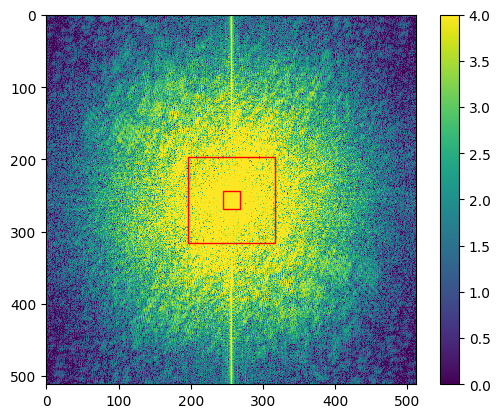

In [39]:
if model.use_masks:
    model.use_masks = False
    plot_model_init_fft(model, (sidelength, sidelength), bandlimit, low_range)
    model.use_masks = True
else:
    plot_model_init_fft(model, (sidelength, sidelength), bandlimit, low_range)

# Training

In [ ]:
from typing import Tuple
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter

import os

from tqdm.autonotebook import tqdm
import copy
import gc


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad


def cond_mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def train(
    model: SASNet,
    gt: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    loss_fns: dict,
    img_size: Tuple[int, int],
    num_epochs: int,
    out_dir: str,
    writer: SummaryWriter,
    summary_interval: int,
    summary_fn: callable = None,
) -> SASNet:
    checkpoints_dir = os.path.join(out_dir, "checkpoints")
    cond_mkdir(checkpoints_dir)

    model = model.cuda()
    model.train()
    optimizer.zero_grad()

    start_time = time.time()
    pbar = tqdm(
        range(num_epochs),
        desc="Training",
        postfix={"psnr": "nan"},
    )

    coords = make_grid(img_size, center=True) * 0.95
    coords = coords.cuda()
    gt = gt.cuda()

    best_loss = float("inf")
    best_state_dict = None
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        psnr = None
        losses = defaultdict(float)

        model_out = model(coords)
        output = torch.clamp(model_out["model_out"], -1.0, 1.0)

        total_loss = torch.zeros(1).cuda()
        for loss_name, (loss_fn, loss_weight) in loss_fns.items():
            loss = loss_fn(
                output,
                gt,
                input_masks=model_out["input_masks"],
                all_hidden_masks=model_out["all_hidden_masks"],
            )
            losses[loss_name] += loss.item()

            total_loss += loss_weight * loss
        losses["total_loss"] += total_loss.item()

        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        for loss_name, loss_value in losses.items():
            if loss_name == "image_mse":
                psnr = -10 * np.log10(loss_value)
                # NOTE: the value range of the image is [-1, 1] here instead of [0, 1]
                writer.add_scalar("train/psnr", psnr, epoch)
            writer.add_scalar(f"train/{loss_name}", loss_value, epoch)

        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_state_dict = copy.deepcopy(model.state_dict())

        if epoch % summary_interval == 0:
            tqdm.write(
                "Epoch %d, Total loss %0.6f, epoch time %0.6f"
                % (epoch, total_loss.item(), time.time() - start_time)
            )

            if summary_fn is not None:
                summary_fn(model, epoch, writer)

            torch.cuda.empty_cache()
            gc.collect()

        pbar.update(1)
        pbar.set_postfix(psnr=f"{psnr:.2f}")

    writer.close()

    # save model
    torch.save(model.state_dict(), os.path.join(checkpoints_dir, "model_final.pth"))
    torch.save(best_state_dict, os.path.join(checkpoints_dir, "model_best.pth"))

    print(f"Model saved at {checkpoints_dir}")

    # clear memory
    gc.collect()
    del coords, model_out, output
    torch.cuda.empty_cache()

    model.load_state_dict(best_state_dict)
    return model

In [37]:
def image_mse(output, gt, **kwargs):
    return torch.mean((output - gt) ** 2)


def hidden_mask_l1_loss(output, gt, **kwargs):
    all_hidden_masks = kwargs.get("all_hidden_masks", None)
    loss = torch.tensor(0.0).to(output.device)
    if all_hidden_masks is not None:
        # N x num_neuron_groups, value range [0, 1]
        for i, mask in enumerate(all_hidden_masks):
            if mask is not None:
                loss += mask.mean()
    return loss


Training:   0%|                                                 | 0/5001 [00:00<?, ?it/s, psnr=nan]

Training:   0%|                                        | 2/5001 [00:00<44:31,  1.87it/s, psnr=6.03]

Epoch 0, Total loss 0.272160, epoch time 0.383443


Training:  10%|███▋                                 | 502/5001 [00:15<03:05, 24.31it/s, psnr=22.84]

Epoch 500, Total loss 0.005205, epoch time 15.450052


Training:  20%|███████▏                            | 1002/5001 [00:30<02:47, 23.92it/s, psnr=25.97]

Epoch 1000, Total loss 0.002534, epoch time 30.542271


Training:  30%|██████████▊                         | 1503/5001 [00:45<02:20, 24.89it/s, psnr=27.97]

Epoch 1500, Total loss 0.001597, epoch time 45.634392


Training:  40%|██████████████▍                     | 2003/5001 [01:00<01:57, 25.52it/s, psnr=29.28]

Epoch 2000, Total loss 0.001179, epoch time 60.645023


Training:  50%|██████████████████                  | 2503/5001 [01:15<01:39, 25.15it/s, psnr=30.26]

Epoch 2500, Total loss 0.000945, epoch time 75.650193


Training:  60%|█████████████████████▌              | 3003/5001 [01:30<01:17, 25.77it/s, psnr=31.05]

Epoch 3000, Total loss 0.000787, epoch time 90.639874


Training:  70%|█████████████████████████▏          | 3503/5001 [01:45<00:59, 25.01it/s, psnr=31.62]

Epoch 3500, Total loss 0.000691, epoch time 105.635201


Training:  80%|████████████████████████████▊       | 4003/5001 [02:00<00:39, 25.39it/s, psnr=32.12]

Epoch 4000, Total loss 0.000615, epoch time 120.632546


Training:  90%|████████████████████████████████▍   | 4503/5001 [02:15<00:19, 25.76it/s, psnr=32.34]

Epoch 4500, Total loss 0.000580, epoch time 135.606310


Training: 100%|████████████████████████████████████| 5001/5001 [02:30<00:00, 25.13it/s, psnr=32.55]

Epoch 5000, Total loss 0.000556, epoch time 150.571787
Model saved at ./output/checkpoints


Training: 100%|████████████████████████████████████| 5001/5001 [02:30<00:00, 33.15it/s, psnr=32.55]


In [ ]:
# SIREN model
exp_name = "siren"
out_dir = f"./output/{exp_name}"
cond_mkdir(out_dir)

model = SASNet(
    in_features=n_input_dims,
    hidden_features=[185, 185, 185],
    hidden_layers=2,
    out_features=n_output_dims,
    bias=True,
    omega_0=43,
    init_mode="none",
    mask_config={},
)

loss_fns = {
    "image_mse": (image_mse, 1.0),
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

summaries_dir = os.path.join(out_dir, "summaries")
cond_mkdir(summaries_dir)
model = train(
    model,
    gt,
    optimizer,
    loss_fns,
    (sidelength, sidelength),
    5001,
    out_dir,
    SummaryWriter(summaries_dir),
    500,
)

No initialization for the first layer.


In [ ]:
exp_name = "sasnet"
out_dir = f"./output/{exp_name}"
cond_mkdir(out_dir)

# SASNet model
random_seed = 42

num_high_freq_bands = 5
mask_config = {
    "input_masks": True,
    "hidden_masks": True,
    "low_freq_mask": False,
    "masked_hidden_layer_groups": [8, 8],
}
decoder_hidden_dims = 32
decoder_output_dims = num_high_freq_bands + sum(
    mask_config["masked_hidden_layer_groups"]
)
grid_config = {
    "otype": "HashGrid",
    "n_levels": 10,
    "n_features_per_level": 2,
    "log2_hashmap_size": 12,
    "base_resolution": 4,
    "per_level_scale": 1.26 ,
}
grid = tcnn.Encoding(n_input_dims, grid_config, seed=random_seed)

# NOTE: this MLP with sigmoid output does not perform as nn.Linear MLP with sigmoid output.
# decoder = tcnn.Network(
#     grid.n_output_dims,
#     decoder_output_dims,
#     {
#         "otype": "FullyFusedMLP",
#         "activation": "ReLU",
#         "output_activation": "Sigmoid",
#         "n_neurons": decoder_hidden_dims,
#         "n_hidden_layers": 1,
#     },
#     seed=random_seed,
# )

decoder = MLP(
    in_features=grid.n_output_dims,
    hidden_features=[48],
    out_features=decoder_output_dims,
    hidden_layers=1,
    act_func=torch.relu,
    output_act_func=torch.sigmoid,
)

bandlimit = 60
low_range = 12
perc_low_freqs = 0.5

model = SASNet(
    in_features=n_input_dims,
    hidden_features=[400, 116, 116],
    hidden_layers=2,
    out_features=n_output_dims,
    bias=True,
    period=2.0,
    bandlimit=bandlimit,
    low_range=low_range,
    perc_low_freqs=perc_low_freqs,
    num_high_freq_bands=num_high_freq_bands,
    omega_0=43,
    init_mode="sampling",
    use_masks=True,
    grid=grid,
    decoder=decoder,
    mask_config=mask_config,
)

loss_fns = {
    "image_mse": (image_mse, 1.0),
    "hidden_mask_l1": (hidden_mask_l1_loss, 1e-4), # 5e-4, 3e-4
}

optimizer = torch.optim.Adam([
    {"params": model.sin_net.parameters(), "lr": 1e-4},
    {"params": model.grid.parameters(), "lr": 1e-3},
    {"params": model.decoder.parameters(), "lr": 1e-3}, # 5e-4
])

summaries_dir = os.path.join(out_dir, "summaries")
cond_mkdir(summaries_dir)
model = train(
    model,
    gt,
    optimizer,
    loss_fns,
    (sidelength, sidelength),
    5001,
    out_dir,
    SummaryWriter(summaries_dir),
    500,
)

self.__bandlimit = 60, self.__low_range = 12, self.__perc_low_freqs = 0.5
Initializing periodic sampling
low_freq_candidates.shape = (324, 2), high_freq_candidates.shape = (310, 2)
self.n_low_freqs = 198, self.n_high_freqs = 200
band.shape = (18, 2)
band.shape = (34, 2)
band.shape = (38, 2)
band.shape = (48, 2)
band.shape = (62, 2)
Initialization done.


Training:   0%|                                                 | 0/5001 [00:00<?, ?it/s, psnr=nan]



                                                                                                   
Training:   0%|                                                 | 0/5001 [00:00<?, ?it/s, psnr=nan]

Epoch 0, Total loss 0.241846, epoch time 0.129444


Training:  10%|███▋                                 | 500/5001 [00:44<06:33, 11.44it/s, psnr=30.41]

                                                                                                   
Training:  10%|███▋                                 | 501/5001 [00:44<08:26,  8.89it/s, psnr=30.44]

Epoch 500, Total loss 0.001069, epoch time 44.273260


Training:  20%|███████▏                            | 1000/5001 [01:28<06:17, 10.61it/s, psnr=32.22]

                                                                                                   
Training:  20%|███████▏                            | 1001/5001 [01:28<07:45,  8.59it/s, psnr=32.22]

Epoch 1000, Total loss 0.000765, epoch time 88.773984


Training:  30%|██████████▊                         | 1500/5001 [02:12<05:02, 11.57it/s, psnr=32.80]

                                                                                                   
Training:  30%|██████████▊                         | 1501/5001 [02:12<06:22,  9.14it/s, psnr=32.81]

Epoch 1500, Total loss 0.000685, epoch time 132.490175


Training:  40%|██████████████▍                     | 2000/5001 [02:56<04:19, 11.58it/s, psnr=33.22]

                                                                                                   
Training:  40%|██████████████▍                     | 2001/5001 [02:56<05:28,  9.14it/s, psnr=33.21]

Epoch 2000, Total loss 0.000635, epoch time 176.579528


Training:  50%|█████████████████▉                  | 2500/5001 [03:40<03:40, 11.34it/s, psnr=33.54]

                                                                                                   
Training:  50%|██████████████████                  | 2501/5001 [03:40<04:39,  8.96it/s, psnr=33.54]

Epoch 2500, Total loss 0.000597, epoch time 220.138023


Training:  60%|█████████████████████▌              | 3000/5001 [04:23<02:53, 11.50it/s, psnr=33.71]

                                                                                                   
Training:  60%|█████████████████████▌              | 3001/5001 [04:23<03:46,  8.84it/s, psnr=33.71]

Epoch 3000, Total loss 0.000577, epoch time 263.796088


Training:  70%|█████████████████████████▏          | 3500/5001 [05:07<02:11, 11.43it/s, psnr=33.74]

                                                                                                   
Training:  70%|█████████████████████████▏          | 3501/5001 [05:07<02:46,  9.01it/s, psnr=33.75]

Epoch 3500, Total loss 0.000571, epoch time 307.655496


Training:  80%|████████████████████████████▊       | 4000/5001 [05:50<01:27, 11.47it/s, psnr=34.10]

                                                                                                   
Training:  80%|████████████████████████████▊       | 4001/5001 [05:50<01:50,  9.04it/s, psnr=34.10]

Epoch 4000, Total loss 0.000535, epoch time 350.549032


Training:  90%|████████████████████████████████▍   | 4500/5001 [06:34<00:43, 11.57it/s, psnr=34.19]

                                                                                                   
Training:  90%|████████████████████████████████▍   | 4501/5001 [06:34<00:55,  8.99it/s, psnr=34.20]

Epoch 4500, Total loss 0.000525, epoch time 394.219811


Training: 100%|███████████████████████████████████▉| 5000/5001 [07:16<00:00, 11.60it/s, psnr=34.27]

                                                                                                   
Training: 100%|████████████████████████████████████| 5001/5001 [07:17<00:00,  8.92it/s, psnr=34.27]

Epoch 5000, Total loss 0.000516, epoch time 436.983491
Model saved at ./output/sasnet7/checkpoints


Training: 100%|████████████████████████████████████| 5001/5001 [07:17<00:00, 11.44it/s, psnr=34.27]


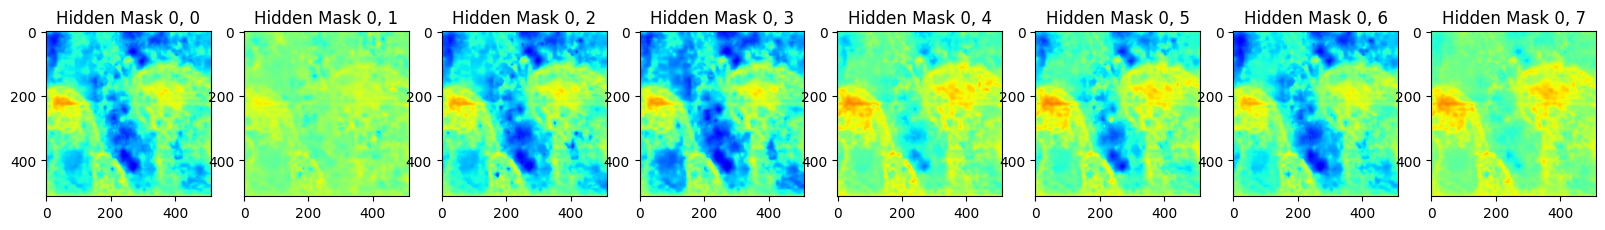

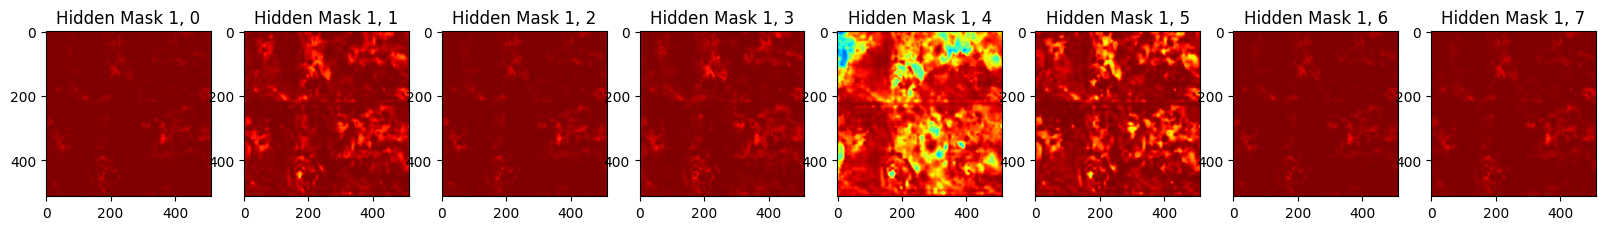

# Test

In [121]:
def eval_model(model, sidelength, gt_img):
    model.cuda()
    model.eval()
    with torch.no_grad():
        coords = make_grid((sidelength, sidelength), center=True) * 0.95
        coords = coords.cuda()
        model_out = model(coords)
        output = torch.clamp(model_out["model_out"], -1.0, 1.0)
        output_img = (
            einops.rearrange(output, "(h w) c -> h w c", h=sidelength, w=sidelength)
            .cpu()
            .detach()
            .numpy()
            * 0.5
            + 0.5
        )

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_img)
        axes[0].set_title("Ground Truth")
        axes[1].imshow(np.abs(gt_img - output_img).mean(-1), cmap="jet", vmin=0, vmax=0.02)
        axes[1].set_title(f"Error map: {-10 * np.log10(np.mean((output_img - gt_img) ** 2)):.3f} dB")
        plt.show()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(
            img_fft(rgb2gray(gt_img)), vmin=2, vmax=8, interpolation="none"
        )
        axes[0].set_title("Ground Truth FFT")
        axes[1].imshow(
            img_fft(rgb2gray(output_img)), vmin=2, vmax=8, interpolation="none"
        )
        axes[1].set_title("Output FFT")
        plt.show()

    if model.use_masks:
        input_masks = model_out["input_masks"].view(sidelength, sidelength, num_high_freq_bands + 1).cpu().detach().numpy()

        # plot the input masks
        fig, axes = plt.subplots(1, num_high_freq_bands + 1, figsize=(20, 5))
        for i in range(num_high_freq_bands + 1):
            axes[i].imshow(input_masks[:, :, i], vmin=0, vmax=1, cmap="coolwarm")
            axes[i].set_title(f"Input Mask {i}")
        plt.show()
    
        # hidden masks
        all_hidden_masks = model_out["all_hidden_masks"]

        for i, hidden_masks in enumerate(all_hidden_masks):
            if hidden_masks is not None:
                hidden_masks = hidden_masks.view(sidelength, sidelength, mask_config["masked_hidden_layer_groups"][i]).cpu().detach().numpy()
                # plot the hidden masks
                fig, axes = plt.subplots(1, mask_config["masked_hidden_layer_groups"][i], figsize=(20, 5))
                for j in range(mask_config["masked_hidden_layer_groups"][i]):
                    axes[j].imshow(hidden_masks[:, :, j], vmin=0, vmax=1, cmap="jet")
                    axes[j].set_title(f"Hidden Mask {i}, {j}")
        plt.show()

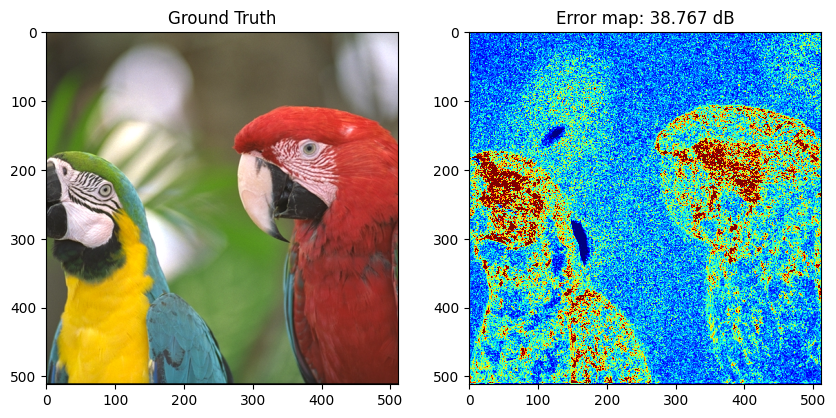

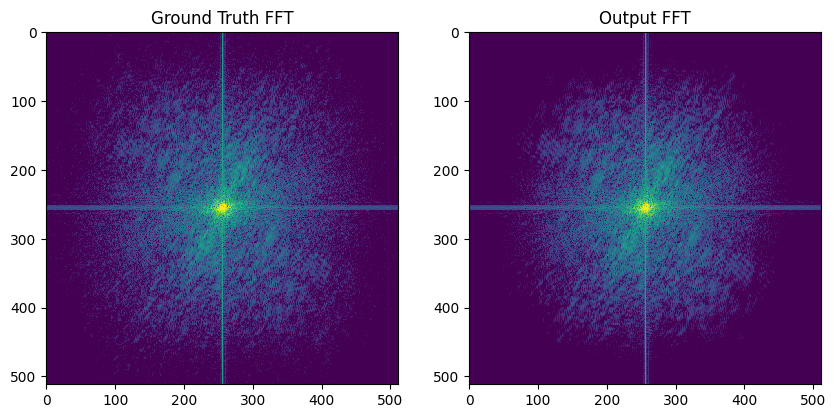

In [ ]:
# SIREN
model = SASNet(
    in_features=n_input_dims,
    hidden_features=[185, 185, 185],
    hidden_layers=2,
    out_features=n_output_dims,
    bias=True,
    omega_0=43,
    init_mode="none",
    mask_config={},
)
model.load_state_dict(torch.load("./output/siren/checkpoints/model_best.pth"))
eval_model(model, sidelength, gt_img)

self.__bandlimit = 60, self.__low_range = 12, self.__perc_low_freqs = 0.5
Initializing periodic sampling
low_freq_candidates.shape = (324, 2), high_freq_candidates.shape = (310, 2)
self.n_low_freqs = 198, self.n_high_freqs = 200
band.shape = (18, 2)
band.shape = (34, 2)
band.shape = (38, 2)
band.shape = (48, 2)
band.shape = (62, 2)
Initialization done.


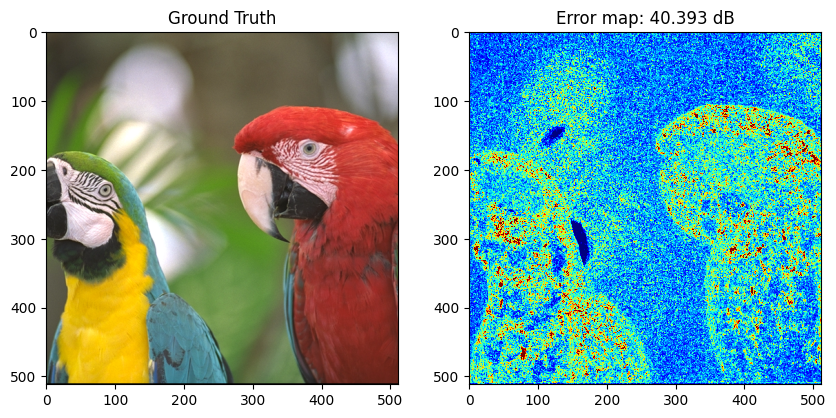

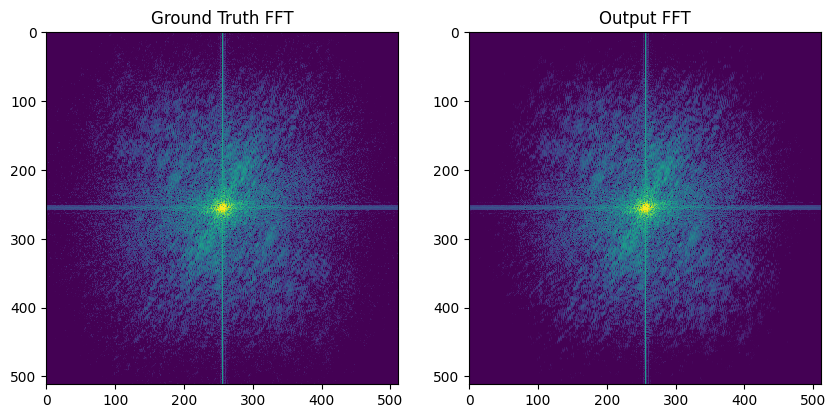

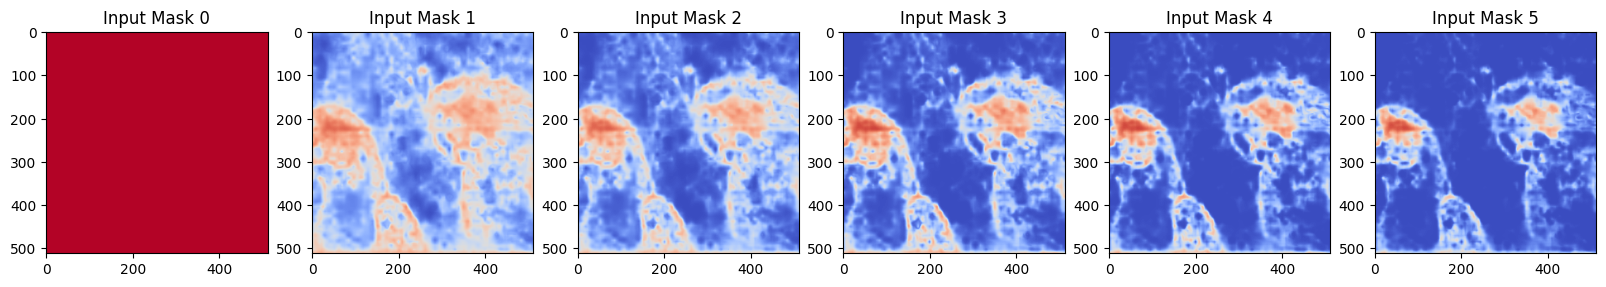

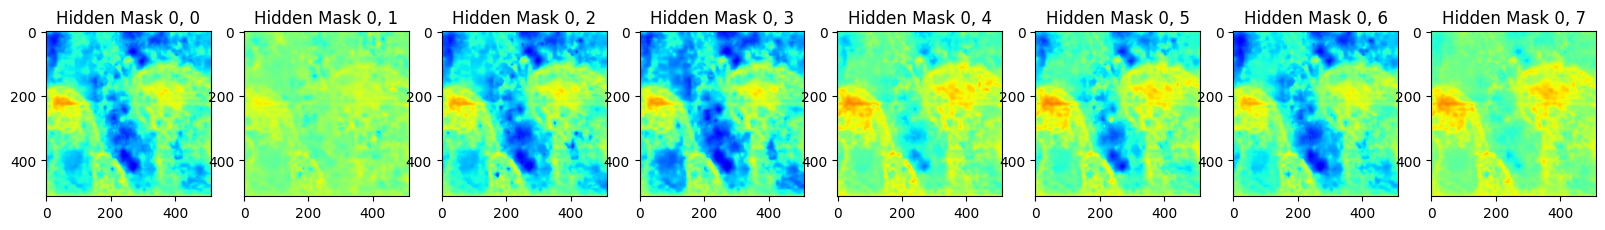

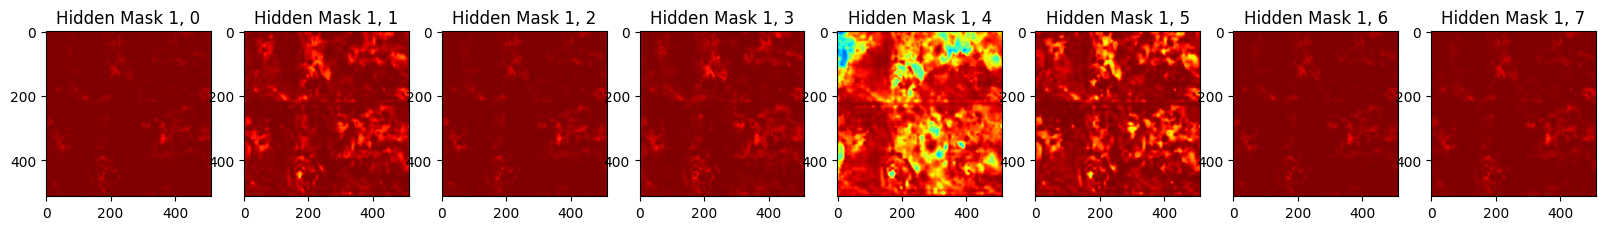

In [123]:
# SASNet
grid = tcnn.Encoding(n_input_dims, grid_config, seed=random_seed)
decoder = MLP(
    in_features=grid.n_output_dims,
    hidden_features=[48],
    out_features=decoder_output_dims,
    hidden_layers=1,
    act_func=torch.relu,
    output_act_func=torch.sigmoid,
)

model = SASNet(
    in_features=n_input_dims,
    hidden_features=[400, 116, 116],
    hidden_layers=2,
    out_features=n_output_dims,
    bias=True,
    period=2.0,
    bandlimit=bandlimit,
    low_range=low_range,
    perc_low_freqs=perc_low_freqs,
    num_high_freq_bands=num_high_freq_bands,
    omega_0=43,
    init_mode="sampling",
    use_masks=True,
    grid=grid,
    decoder=decoder,
    mask_config=mask_config,
)
model.load_state_dict(torch.load("./output/sasnet/checkpoints/model_best.pth"))
eval_model(model, sidelength, gt_img)

# What is next?

1. Add sparsity loss term
2. See if the hash grid features can be initialized as in WISP (bias = 0, std = 1.0e-09).
3. Check the hash grid levels are equivalent to the WISP levels:
    ```
        [grid]
        grid_feature_dim = 2
        grid_num_lods = 10
        grid_multiscale_type = 'cat'
        grid_coord_dim = 2
        grid_feature_std = 1.0e-09
        grid_feature_bias = 0.0
        grid_codebook_bitwidth = 12
        grid_min_grid_res = 4
        grid_finest_res = 5 ; sidelength of the smallest grid cell
        grid_lr = 5.0e-4
    ```
4. 